In [20]:
import sys
sys.version_info
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time
import random

In [21]:
pd.set_option('display.max_columns', None)

## First: load in our data and do some basic analysis to look for problems

In [22]:
#read in the data
marathon_data = pd.read_csv("data.csv")
marathon_data = marathon_data.dropna()
marathon_data['Time'] = pd.to_timedelta(marathon_data['Time'])
marathon_data.head()

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
0,1,carlos enrique portugal quintero,30,M,1263,04:15:00,09:44,2016
1,2,leonel furlan,60,M,2289,05:05:42,11:41,2016
2,3,meredith gray,30,F,2276,05:04:34,11:38,2016
3,4,jason ainspan,35,M,670,03:52:57,08:53,2015
4,4,jason ainspan,35,M,2390,05:13:30,11:58,2016


In [23]:
marathon_data.groupby("Id").size().sort_values(ascending = False).head(2)
#Clearly we have a problem with this ID
#marathon_data[marathon_data["Id"] == 3327]

Id
3327    347
1640     13
dtype: int64

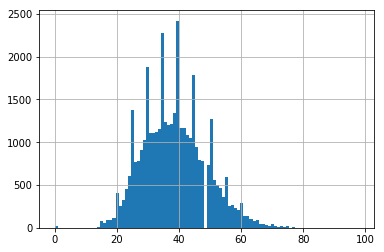

In [24]:
marathon_data["Age Category"].hist(bins = 100)

In [25]:
marathon_data.groupby("Year").size()

Year
2003    1455
2004    1770
2005    1761
2006    2463
2007    2537
2008    2633
2009    2765
2010    2880
2011    3537
2012    3912
2013    3782
2014    3541
2015    2752
2016    3016
dtype: int64

In [26]:
sum(np.where(marathon_data.groupby("Year").get_group(2013).groupby("Name").size() > 1, 1,0))

31

In [27]:
for yr in marathon_data.groupby('Year').groups: 
    print(yr, str(marathon_data.groupby('Year').get_group(yr)['Time'].mean()), str(marathon_data.groupby('Year').get_group(yr)['Time'].var()))
    print(sum(np.where(marathon_data.groupby("Year").get_group(yr).groupby("Name").size() > 1, 1,0)))
    #here, we are trying to figure out which year was the half marathon (2013)
#Let's drop that year
#marathon_data = marathon_data[marathon_data.Year != 2013]
#marathon_data.Year.value_counts()

2016 0 days 04:32:55.103116 9.67006501192e+24
6
2003 0 days 04:18:00.990378 8.18779093801e+24
2
2004 0 days 04:28:34.934463 8.30994055534e+24
4
2005 0 days 04:25:55.415105 9.27648910998e+24
5
2006 0 days 04:37:25.943564 1.1672408613e+25
5
2007 0 days 04:43:34.228222 1.09763685603e+25
9
2008 0 days 04:28:04.394986 8.08759365244e+24
6
2009 0 days 04:29:01.636166 8.61337524601e+24
5
2010 0 days 04:36:43.382291 8.63934445992e+24
7
2011 0 days 04:27:12.712468 8.18099172641e+24
12
2012 0 days 04:35:52.052658 8.50791826672e+24
18
2013 0 days 01:51:27.648069 3.48945714515e+23
31
2014 0 days 04:43:50.870375 8.72552921511e+24
18
2015 0 days 04:30:48.480377 9.10367929878e+24
6


In [28]:
marathon_data.groupby("Year").get_group(2013)["Time"].max()

Timedelta('0 days 02:04:02')

In [29]:
marathon_data.groupby("Year").get_group(2013)["Time"].min() 

Timedelta('0 days 01:05:44')

In [30]:
marathon_data.groupby("Year").get_group(2013)["Time"].describe()

count                      3782
mean     0 days 01:51:27.648069
std      0 days 00:09:50.716272
min             0 days 01:05:44
25%      0 days 01:45:45.250000
50%             0 days 01:53:43
75%             0 days 01:59:20
max             0 days 02:04:02
Name: Time, dtype: object

In [31]:
  marathon_data[marathon_data["Year"] != 2013].Time.mean() / marathon_data.groupby("Year").get_group(2013)["Time"].mean()

2.450648476425932

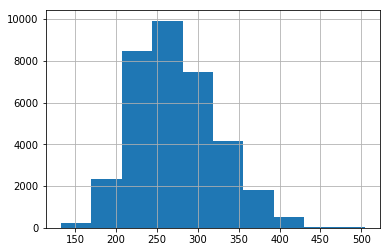

In [32]:
(marathon_data[marathon_data["Year"] != 2013]["Time"] / pd.Timedelta(minutes = 1)).hist()
#Histogram of the finishing times for all years except 2013, in minutes

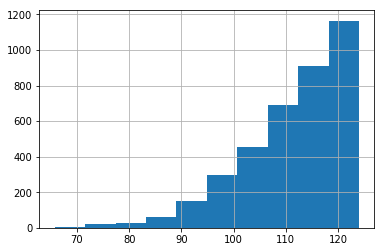

In [33]:
(marathon_data.groupby("Year").get_group(2013)["Time"] / pd.Timedelta(minutes = 1)).hist()
#Histogram of the finishing times for 2013, in minutes

In [34]:
##Do we want to remove the entries without valid name?

#marathon_data.Name.value_counts().sort_values().tail()
#Note: we see that some of the participants have the name set to private. we should probably drop these 
#marathon_data = marathon_data[marathon_data.Name != "private"]
#marathon_data.Name.value_counts().sort_values().tail()
#marathon_data = marathon_data[marathon_data.Name.str.contains("#") == False]
#get rid of one garbage name

In [35]:
marathon_data.sort_values('Time').head()
#This looks good (all the very low times are winners of the race, or close to it)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
33820,25606,robert mbithi,23,M,1,01:05:44,05:01,2013
31834,23730,danilo briceno,31,M,2,01:10:41,05:23,2013
30990,22939,fornes jose,27,M,3,01:10:57,05:24,2013
31504,23420,leo kormanik ii,30,M,3,01:10:57,05:24,2013
32479,24335,mauricio cruz,17,M,5,01:11:37,05:28,2013


In [36]:
marathon_data.groupby('Name').size().sort_values(ascending = False).head(2)
#This is reasonable, we se that some people participated in the marathon each year that it occured

Name
private            347
paul schoenlaub     13
dtype: int64

In [37]:
marathon_data.groupby("Id").size().sort_values(ascending = False).head(2)

Id
3327    347
1640     13
dtype: int64

## Now, we have clean data but need to extract the features for our models

In [86]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")

data_pivot["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:14].count() , axis = 1)
for yr in marathon_data.groupby('Year').groups:
    print("Number attending in " + str(yr) + " who also attended in other years = " + str(sum(data_pivot.loc[np.invert(pd.isnull(data_pivot["Rank"][yr]))]["Num Marathons"].apply(lambda x: 1 if x > 1 else 0))))

Number attending in 2016 who also attended in other years = 793
Number attending in 2003 who also attended in other years = 502
Number attending in 2004 who also attended in other years = 679
Number attending in 2005 who also attended in other years = 692
Number attending in 2006 who also attended in other years = 780
Number attending in 2007 who also attended in other years = 850
Number attending in 2008 who also attended in other years = 864
Number attending in 2009 who also attended in other years = 1021
Number attending in 2010 who also attended in other years = 1093
Number attending in 2011 who also attended in other years = 1232
Number attending in 2012 who also attended in other years = 1254
Number attending in 2013 who also attended in other years = 752
Number attending in 2014 who also attended in other years = 1085
Number attending in 2015 who also attended in other years = 882


In [88]:
data_pivot.head(2)

Rank                                                                    \
Year  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014   
Id                                                                             
1     None  None  None  None  None  None  None  None  None  None  None  None   
2     None  None  None  None  None  None  None  None  None  None  None  None   

                 Age Category                                                  \
Year  2015  2016         2003  2004  2005  2006  2007  2008  2009  2010  2011   
Id                                                                              
1     None  1263         None  None  None  None  None  None  None  None  None   
2     None  2289         None  None  None  None  None  None  None  None  None   

                                   Time                                      \
Year  2012  2013  2014  2015 2016  2003  2004  2005  2006  2007  2008  2009   
Id                                                                            
1     None  None  None  None   30  None  None  None  None  None  None  None   
2     None  None  None  None   60  None  None  None  None  None  None  None   

                                                          Num Marathons  
Year  2010  2011  2012  2013  2014  2015             2016                
Id                                                                       
1     None  None  None  None  None  None  0 days 04:15:00             1  
2     None  None  None  None  None  None  0 days 05:05:42             1

In [109]:
data_pivot.iloc[0].iloc[0:(12)]

      Year
Rank  2003    None
      2004    None
      2005    None
      2006    None
      2007    None
      2008    None
      2009    None
      2010    None
      2011    None
      2012    None
      2013    None
      2014    None
Name: 1, dtype: object

In [110]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")

def create_frame(last_year):
    start = time.time()
    
    #This is the function to create a frame with the relavant features for each runner, given a year
    #The basic process is we create a pandas pivot table to help us, then we iterate over this pivot table (mostly using apply)
    #to create a new pandas dataframe (new_frame) that contains all relavent features 
    
    #the year we input (last_year) is the last year that we look at (1 year back from current)
    #IE, if we are looking to train a model to predict for 2017, we would give 2015 as the last_year, and the features would include all years up to 2015
    #Then, to predict for 2017 we input 2016 to include features
    
    new_frame = pd.DataFrame(data = {"Id": marathon_data.Id, "Sex": marathon_data.Sex})
    new_frame = new_frame.drop_duplicates("Id")
    new_frame["Sex"] = pd.get_dummies(new_frame["Sex"])
    #1 is male, 0 is female
    
    new_frame.index = new_frame.Id
    
    #helper functions
    def lastfilled(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key-1
            #if (key == 2013):
            #    key = key - 1
            if (key < 2003): 
                return None 
        return (last_year - key + 1)
        
    def valuelast(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key - 1
            #if (key == 2013):
            #    key = key - 1
            if (key < 2003): 
                return None
        return row.loc[key]
    
    for i in range(0,(last_year - 2002)):
        #Here we iterate over the relavent columns in order to get the dummies for participation
        #Each column will be a boolean variable, with a 1 if the runner participated that year, and a 0 otherwise
        #the output is expressed in terms of lags: IE, Lag_1 is one year ago, Lag_4 is 4 years ago...
        new_frame["_".join(("Lag",str(i + 1)))] = pd.isnull(data_pivot["Rank"]).iloc[:,(last_year - 2003 - i)].apply(lambda x: 0 if x else 1)

    new_frame["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:(last_year - 2002)].count() , axis = 1)
    #number of marathons ran
    new_frame["Years Since Last"] = data_pivot.apply(lambda x: lastfilled(x["Rank"]), axis = 1)
    #years since last ra 
    new_frame["Time of Last"] = data_pivot.apply(lambda x: valuelast(x["Time"]), axis = 1)
    #time of the last marathon they competed in 
    new_frame["Age Last"] = data_pivot.apply(lambda x: valuelast(x["Age Category"]), axis = 1)
    #NOTE: these apply functions are very time-costly. It takes around 60seconds to run this function fully
    #It would be possible to optimize this, but I am not sure if it is worth my time
    
    #Normalization on the time column 
    new_frame["Time of Last"] = (new_frame["Time of Last"] - new_frame["Time of Last"].min()) / (new_frame["Time of Last"].max() - new_frame["Time of Last"].min())
    new_frame["Age Last"] = (new_frame["Age Last"] - new_frame["Age Last"].min()) / (new_frame["Age Last"].max() - new_frame["Age Last"].min())
    
    new_frame["Dummy"] = np.ones(len(new_frame))
    
    del new_frame["Id"]
    
    print(time.time() - start)
    return new_frame

In [111]:
my_frame = create_frame(2015)

63.303378105163574


In [114]:
my_frame.head(5)

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Num Marathons,Years Since Last,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,,,,
1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0
2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0
3,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0
4,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.380932,0.357143,1.0
5,1.0,0,1,0,1,1,1,1,1,1,1,0,0,0,8,2.0,0.632166,0.428571,1.0


In [115]:
data_pivot.head(5)

Rank                                                                    \
Year  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014   
Id                                                                             
1     None  None  None  None  None  None  None  None  None  None  None  None   
2     None  None  None  None  None  None  None  None  None  None  None  None   
3     None  None  None  None  None  None  None  None  None  None  None  None   
4     None  None  None  None  None  None  None  None  None  None  None  None   
5     None  None  None  2013  2002  2343  2415  2455  3140  3329  None  3086   

                 Age Category                                                  \
Year  2015  2016         2003  2004  2005  2006  2007  2008  2009  2010  2011   
Id                                                                              
1     None  1263         None  None  None  None  None  None  None  None  None   
2     None  2289         None  None  None  None  None  None  None  None  None   
3     None  2276         None  None  None  None  None  None  None  None  None   
4      670  2390         None  None  None  None  None  None  None  None  None   
5     None  2608         None  None  None    34    35    36    37    38    39   

                                   Time                               \
Year  2012  2013  2014  2015 2016  2003  2004  2005             2006   
Id                                                                     
1     None  None  None  None   30  None  None  None             None   
2     None  None  None  None   60  None  None  None             None   
3     None  None  None  None   30  None  None  None             None   
4     None  None  None    35   35  None  None  None             None   
5       40  None    42  None   40  None  None  None  0 days 05:29:32   

                                                                          \
Year             2007             2008             2009             2010   
Id                                                                         
1                None             None             None             None   
2                None             None             None             None   
3                None             None             None             None   
4                None             None             None             None   
5     0 days 05:26:12  0 days 05:28:49  0 days 05:27:27  0 days 05:29:04   

                                                               \
Year             2011             2012  2013             2014   
Id                                                              
1                None             None  None             None   
2                None             None  None             None   
3                None             None  None             None   
4                None             None  None             None   
5     0 days 05:28:24  0 days 05:28:35  None  0 days 05:43:14   

                                        
Year             2015             2016  
Id                                      
1                None  0 days 04:15:00  
2                None  0 days 05:05:42  
3                None  0 days 05:04:34  
4     0 days 03:52:57  0 days 05:13:30  
5                None  0 days 05:28:34

In [41]:
my_frame.as_matrix()
#As you can see, we can represent this data as a matrix as well:

array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,  1.        ],
       [ 1.        ,  0.        ,  0.        , ...,         nan,
                nan,  1.        ],
       ..., 
       [ 1.        ,  0.        ,  0.        , ...,  0.36259397,
         0.45918367,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.37785709,
         0.35714286,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.23851469,
         0.40816327,  1.        ]])

## Now: Logistic Regression 

As logistic regression is a supervised learning model, we need to train the model using a y-vector of instances of correct categorization that we have. This is acomplished by using 2016 as our  categorization year, and using as our features set the data on participation in races from 2003 to 2015. In this case, we exclude all participants who do not have a race between 2003 and 2015 (those who only race in 2016). 

In [42]:
#Create our dataframe, looking back from 2016
train_df = create_frame(2015)
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0 ]
del train_df["Years Since Last"]
train_df["Dummy"] = np.ones(len(train_df))
train_array = train_df.as_matrix()

71.58392810821533


In [43]:
def get_y(year, index): 
    tempy = pd.isnull(data_pivot["Rank"]).iloc[:,((year - 2014))].apply(lambda x: 0 if x else 1)
    tempy = tempy.loc[index]
    return tempy.as_matrix()
# #The other component that we need is our y-vector, which is the participation boolean for 2016
# y_vect = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)
# y_vect = y_vect.loc[train_df.index]
# y_vect = y_vect.as_matrix()
# len(y_vect)

y_vect = get_y(2016, train_df.index)
len(y_vect)

26171

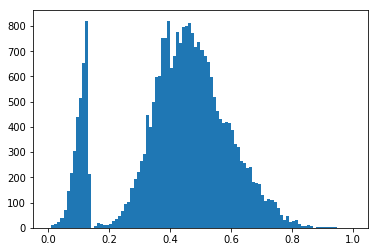

In [44]:
plt.hist(train_df["Time of Last"], bins = 100)
plt.show()

In [45]:
##Here is where we perform the gradient descent
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def error_fxn(w_vect, x_array, y_vect):
    #This function computes the error function, given a weights vector w_vect
    #This allow us to call this function repeatedly as we optimize the w_vect through gradient descent
    y0 = np.log(sigmoid(x_array.dot(w_vect))).dot(y_vect)
    y1 = np.log(1 - sigmoid(x_array.dot(w_vect))).dot(1-y_vect)
    return -(y0 + y1) / len(y_vect)

def grad_fxn(w_vect, x_array, y_vect): 
    #This function computes the gradient function, given the weights vector w_vect
    return (y_vect - sigmoid(np.dot(x_array, w_vect))).dot(x_array)

def grad_descent(w_vect, x_array, y_vect, step, tol, maxi, print_out = True):
    start = time.time()
    #performs the gradient descent
    grad_history = [[w_vect, error_fxn(w_vect, x_array, y_vect)]]
    #store all the past values of the w vector and the error function
    #(we use this to plot the gradient descent or diagnose problems)
    delta = grad_history[0][1]
    delta = 1
    i = 0
    stepi = step
    while(delta > tol): 
        #We continue the descent until the change in error (delta) is less than our tolerance parameter (tol)
        w_old = w_vect
        w_vect = w_old + stepi * grad_fxn(w_old, x_array, y_vect)
        grad_history.append([w_vect, error_fxn(w_vect, x_array, y_vect)])
        delta =  grad_history[-2][1] - grad_history[-1][1]
        stepi = step / (0.1*i + 1)
        #we decrease the step each time to help with convergence
        i = i + 1
        if(i > maxi):
            #We want to end the loop if it has run for two long without converging
            break
    if(print_out):
        print("Loops run = " + str(i))
        print("Time = " + str(time.time() - start))
        print("Exit delta = " + str(delta))
        print("Exit Error = " + str(error_fxn(w_vect, x_array, y_vect)))
        plt.plot([i[1] for i in grad_history])
        plt.title("Gradient Descent")
        plt.xlabel("Iteration")
        plt.ylabel("Error")
        plt.show()
        
    return w_vect, grad_history

Loops run = 10001
Time = 22.76331400871277
Exit delta = 4.41225110882e-07
Exit Error = 0.0290793737975


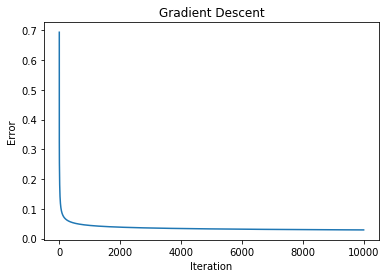

In [46]:
my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = 1e-4, tol = 1e-8, maxi = 10000)

In [47]:
my_w

array([-0.42366746, -0.7173226 , -0.97538891, -0.71974301, -0.62814378,
       -0.50583888, -0.43357945, -0.42139789, -0.1963356 , -0.07325522,
        5.08094308,  0.12178687, -0.07812878,  0.45359583, -1.04081608,
       -0.95554727, -3.08580137])

In [48]:
train_array.shape

(26171, 17)

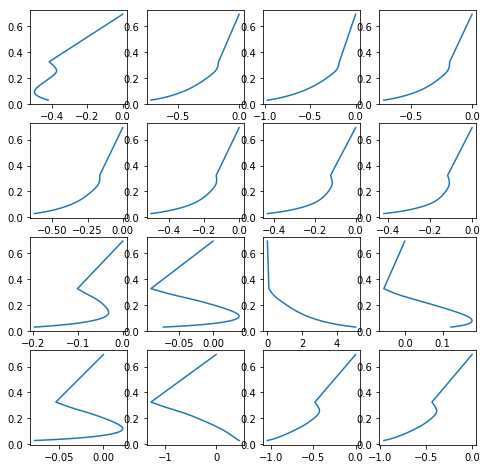

In [49]:
#plot the gradient descent
#We are plotting the cost function (y-axis) of each iteration
#against the value of one position of the w-vector for that iteration
errs = [i[1] for i in grad_history]
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize = (8,8))
j = 0
for ax in axes.reshape(-1): 
    ax.plot([i[0][j] for i in grad_history], errs)
    j = j+1

# Train on pre-2015 to get accuracy of model on 2016

In [50]:
def predict_y(w_vect, x_array): 
    prob_y1 = sigmoid(x_array.dot(w_vect))
    #probability
    part_y = np.where(prob_y1 > 0.5, 1, 0)
    #participation
    return part_y

def prediction_stats(y_pred, y_vect):
    ac = sum(np.invert(np.logical_xor(y_vect, y_pred))) / len(y_vect)
    naive_ac = 1 - sum(y_test) / len(y_vect)
    tpos = sum(y_pred * y_vect)
    sensitivity = tpos / sum(y_vect)
    specificity = (len(y_vect) - sum(np.logical_or(y_vect, y_pred))) / (len(y_vect) - sum(y_vect))
    
    print("Predicted Y1 = " + str(sum(y_pred)))
    print("Accuracy = " + str(ac))
    print("Naive Accuracy = " + str(naive_ac))
    print("Sensitivity = " + str(sensitivity))
    print("Specificity = " + str(specificity))

In [51]:
train_df = create_frame(2014)
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0]
del train_df["Years Since Last"]
train_array = train_df.as_matrix()
train_array.shape

69.57218813896179


(23450, 16)

In [52]:
test_df = create_frame(2015)
test_df = test_df[test_df["Num Marathons"] > 0 ]
del test_df["Years Since Last"]
del test_df["Lag_12"]
test_array = test_df.as_matrix()

66.14812898635864


In [97]:
y_vect = get_y(2015, train_df.index)

In [100]:
len(train_df)

23450

In [99]:
len(test_df)

26171

In [95]:
train_df.head(5)

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Num Marathons,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,
5,1.0,0,1,1,1,1,1,1,1,0,0,0,7,0.632166,0.428571,1.0
9,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0.509986,0.530612,1.0
15,0.0,0,1,1,0,0,1,0,0,0,0,0,3,0.514124,0.377551,1.0
16,0.0,0,1,1,1,1,0,0,0,0,0,0,4,0.415369,0.459184,1.0
22,1.0,0,0,1,0,0,0,0,0,0,0,0,1,0.436252,0.448980,1.0


In [96]:
test_df.head(5)

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Num Marathons,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,
5,1.0,1,0,1,1,1,1,1,1,1,0,0,8,0.632166,0.428571,1.0
7,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0.407738,0.428571,1.0
9,0.0,1,0,1,0,0,0,0,0,0,0,0,2,0.442782,0.510204,1.0
11,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0.597198,0.408163,1.0
15,0.0,0,0,1,1,0,0,1,0,0,0,0,3,0.596742,0.408163,1.0


In [103]:
data_pivot.head(10)

Rank                                                                    \
Year  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014   
Id                                                                             
1     None  None  None  None  None  None  None  None  None  None  None  None   
2     None  None  None  None  None  None  None  None  None  None  None  None   
3     None  None  None  None  None  None  None  None  None  None  None  None   
4     None  None  None  None  None  None  None  None  None  None  None  None   
5     None  None  None  2013  2002  2343  2415  2455  3140  3329  None  3086   
6     None  None  None  None  None  None  None  None  None  None  None  None   
7     None  None  None  None  None  None  None  None  None  None  None   821   
8     None  None  None  None  None  None  None  None  None  None  None  None   
9     None  None  None  None  None  None  None  None  None  1637  None  2023   
10    None  None  None  None  None  None  None  None  None  None  None  None   

                 Age Category                                                  \
Year  2015  2016         2003  2004  2005  2006  2007  2008  2009  2010  2011   
Id                                                                              
1     None  1263         None  None  None  None  None  None  None  None  None   
2     None  2289         None  None  None  None  None  None  None  None  None   
3     None  2276         None  None  None  None  None  None  None  None  None   
4      670  2390         None  None  None  None  None  None  None  None  None   
5     None  2608         None  None  None    34    35    36    37    38    39   
6     None  1845         None  None  None  None  None  None  None  None  None   
7     None   384         None  None  None  None  None  None  None  None  None   
8     None   912         None  None  None  None  None  None  None  None  None   
9     1281  2620         None  None  None  None  None  None  None  None  None   
10    None  1934         None  None  None  None  None  None  None  None  None   

                                   Time                               \
Year  2012  2013  2014  2015 2016  2003  2004  2005             2006   
Id                                                                     
1     None  None  None  None   30  None  None  None             None   
2     None  None  None  None   60  None  None  None             None   
3     None  None  None  None   30  None  None  None             None   
4     None  None  None    35   35  None  None  None             None   
5       40  None    42  None   40  None  None  None  0 days 05:29:32   
6     None  None  None  None   45  None  None  None             None   
7     None  None    42  None   40  None  None  None             None   
8     None  None  None  None   30  None  None  None             None   
9       50  None    52    50   50  None  None  None             None   
10    None  None  None  None   25  None  None  None             None   

                                                                          \
Year             2007             2008             2009             2010   
Id                                                                         
1                None             None             None             None   
2                None             None             None             None   
3                None             None             None             None   
4                None             None             None             None   
5     0 days 05:26:12  0 days 05:28:49  0 days 05:27:27  0 days 05:29:04   
6                None             None             None             None   
7                None             None             None             None   
8                None             None             None             None   
9                None             None             None             None   
10               None             None             None       

In [79]:
my_w

array([-0.43026348, -1.05079811, -0.81775983, -0.70355458, -0.57186026,
       -0.51307682, -0.49178621, -0.32266399, -0.26161271,  0.103343  ,
        4.96142972,  0.1269915 ,  0.45865171, -0.94778156, -0.99826554,
       -2.96402025])

In [65]:
error_fxn(np.zeros(16), train_array, y_vect)

0.69314718055994629

In [66]:
sum(y_pred)

1745

Loops run = 10001
Time = 19.583991050720215
Exit delta = 4.76966812449e-07
Exit Error = 0.0317536933101


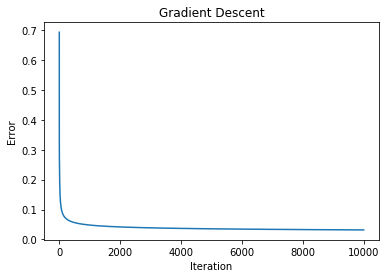

In [81]:
my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = 1e-4, tol = 1e-8, maxi = 10000)

In [82]:
y_test = get_y(2016, test_df.index)
y_pred = predict_y(my_w, test_array)
prediction_stats(y_pred, y_test)

Predicted Y1 = 1745
Accuracy = 1.0
Naive Accuracy = 0.933323143938
Sensitivity = 1.0
Specificity = 1.0


## K-Fold

In [62]:
prediction_stats(y_pred, get_y(2016, test_df.index))

Predicted Y1 = 1745
Accuracy = 1.0
Naive Accuracy = 0.933323143938
Sensitivity = 1.0
Specificity = 1.0


In [ ]:
y_pred = predict_y(my_w, train_array)

print("Predicted Y=1: " + str(sum(y_pred)))
print("Correct predictions for Y=1: " + str(sum(y_pred * y_vect)))
pred_ratio = ratio_predicted(y_pred, y_vect)
print("Ratio of correct predictions: " + str(pred_ratio))
print("Naive in-sample = " + str((1 - sum(y_vect)/ len(y_vect))))
plt.hist(prob_y_pred, bins = 50)
plt.show()

In [ ]:
#Lets try k-fold cross validation.
#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)


k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
#Train on 80% of the data (~20k rows)
k_train_array= train_df.loc[k_train_index].as_matrix()
not_df = train_df.index.isin(k_train_index)
k_test_df = train_df[~not_df]
k_test_array = k_test_df.as_matrix()
#Test with the remaining 20% (~5k rows)

k_y_train = y_df.loc[k_train_index].as_matrix()
#training y-vector
k_y_test = y_df.loc[k_test_df.index].as_matrix()
#testing y-vector

k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                           y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

k_y_pred_train = predict_y(k_w, k_train_array)

k_insample = ratio_predicted(k_y_pred_train, k_y_train)

print()
print("In Sample = " + str(k_insample))
print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
print()

#Now, let's look at the out of sample! 

k_y_pred_test = predict_y(k_w, k_test_array)
k_oos = ratio_predicted(k_y_pred_test, k_y_test)

print("Out of Sample = " + str(k_oos))
print("Naive Out of Sample = " + str((1 - sum(k_y_test)/ len(k_y_test))))

In [ ]:
#Lets try k-fold cross validation.

#TODO: prevent the different folds from overlapping
#This is actually bootstrapping rather than k-fold 

#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)

#Randomize rows at beginning, then take the first 
def kfold(k):
    start = time.time()
    accuracy = []
    
    for i in range(1,k):
        k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
        #Train on 80% of the data (~20k rows)
        k_train_array= train_df.loc[k_train_index].as_matrix()
        not_df = train_df.index.isin(k_train_index)
        k_test_df = train_df[~not_df]
        k_test_array = k_test_df.as_matrix()
        #Test with the remaining 20% (~5k rows)

        k_y_train = y_df.loc[k_train_index].as_matrix()
        #training y-vector
        k_y_test = y_df.loc[k_test_df.index].as_matrix()
        #testing y-vector

        k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                                   y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

        k_y_pred_train = predict_y(k_w, k_train_array)

        k_insample = ratio_predicted(k_y_pred_train, k_y_train)

    #     print()
    #     print("In Sample = " + str(k_insample))
    #     print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
    #     print()

        #Now, let's look at the out of sample! 

        k_y_pred_test = predict_y(k_w, k_test_array)
        k_oos = ratio_predicted(k_y_pred_test, k_y_test)
        k_oos_naive = (1 - sum(k_y_test)/ len(k_y_test))
        accuracy.append((k_oos / k_oos_naive))

    #     print("Out of Sample = " + str(k_oos))
    #     print("Naive Out of Sample = " + str(k_oos_naive)
    print("Time Taken = " + str(time.time() - start))
    print("Average Accuracy Above Naive = " + str(np.mean(accuracy)))

In [ ]:
test_df["Dummies"] = np.ones(len(test_df))
test_df.head()